# Packages

In [2]:
import os
import json
import time
from pathlib import Path
from datetime import datetime
import ast

import pandas as pd
import geopandas as gpd
import numpy as np

# Loading data

In [5]:
football = pd.read_csv("football.csv")

# Exporatory Data Analysis

In [ ]:
football.info() ## we can see there are significant number of missing values in some columns (e.g. under_pressure, shot_deflected, shot_open_goal)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45772 entries, 0 to 45771
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 45772 non-null  object 
 1   index              45772 non-null  int64  
 2   match_id           45772 non-null  int64  
 3   period             45772 non-null  int64  
 4   timestamp          45772 non-null  object 
 5   team               45772 non-null  object 
 6   team_id            45772 non-null  int64  
 7   player             45772 non-null  object 
 8   player_id          45772 non-null  float64
 9   position           45772 non-null  object 
 10  play_pattern       45772 non-null  object 
 11  type               45772 non-null  object 
 12  under_pressure     12292 non-null  object 
 13  shot_deflected     629 non-null    object 
 14  shot_open_goal     484 non-null    object 
 15  shot_type          45772 non-null  object 
 16  shot_statsbomb_xg  457

In [13]:
football.groupby(["position"])["shot_outcome"].count()

position
Center Attacking Midfield    3523
Center Back                   153
Center Defensive Midfield    1038
Center Forward               6965
Goalkeeper                      4
Left Attacking Midfield       135
Left Back                    1692
Left Center Back             1596
Left Center Forward          2905
Left Center Midfield         2417
Left Defensive Midfield      1946
Left Midfield                2108
Left Wing                    4442
Left Wing Back                339
Right Attacking Midfield      162
Right Back                   1532
Right Center Back            1700
Right Center Forward         2746
Right Center Midfield        2185
Right Defensive Midfield     1833
Right Midfield               1973
Right Wing                   4010
Right Wing Back               368
Name: shot_outcome, dtype: int64

In [14]:
football.groupby(["play_pattern"])["shot_outcome"].count()

play_pattern
From Corner        7402
From Counter       2043
From Free Kick     9650
From Goal Kick     1731
From Keeper         778
From Kick Off       504
From Throw In      8104
Other               550
Regular Play      15010
Name: shot_outcome, dtype: int64

In [21]:
# count unique values in under_pressure column
football["under_pressure"].value_counts(dropna=False)

under_pressure
NaN     33480
True    12292
Name: count, dtype: int64

In [23]:
# count unique values in shot_open_goal column
football["shot_open_goal"].value_counts(dropna=False)

shot_open_goal
NaN     45288
True      484
Name: count, dtype: int64

In [7]:
football.groupby(["shot_type"])["shot_outcome"].count()

shot_type
Corner          13
Free Kick     2126
Open Play    43137
Penalty        496
Name: shot_outcome, dtype: int64

Are we going to look at all the periods? Overtime and also penalty kick?

In [8]:
football["period"].value_counts().sort_index()

period
1    20824
2    24926
3        8
4        5
5        9
Name: count, dtype: int64

I am gonna transform shot outcome column into a 0 and 1 column

In [9]:
football["shot_outcome"].unique().tolist()

['Off T',
 'Goal',
 'Blocked',
 'Saved',
 'Wayward',
 'Post',
 'Saved Off Target',
 'Saved to Post']

I will transform timestamp into a minute ceil column (e.g., 4:32 -> 5th minute)

In [10]:
football["timestamp"].unique()

array(['00:04:21.052', '00:06:27.395', '00:08:16.762', ...,
       '00:45:24.473', '00:45:25.517', '00:47:47.998'], dtype=object)

I will transform location to a x and y column by making it a list first

In [11]:
football["location"].head()

0    [108.1, 31.2]
1    [110.9, 42.6]
2    [117.9, 29.1]
3    [101.8, 27.6]
4    [109.3, 26.5]
Name: location, dtype: object

<Axes: xlabel='shot_body_part'>

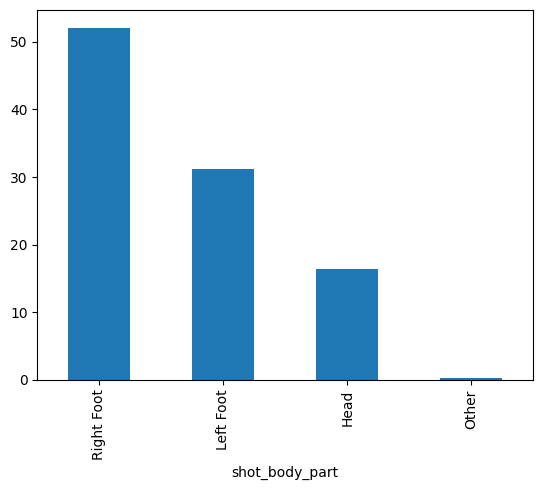

In [12]:
(football["shot_body_part"].value_counts(normalize=True) * 100).plot(kind='bar')

There is no freeze frame data for penalty kicks which makes sense

In [218]:
football[football["shot_freeze_frame"].isna()]["shot_type"].value_counts()

shot_type
Penalty    444
Name: count, dtype: int64

In [280]:
football[(football["period"] != 1) & (football["period"] != 2)].head(2)

,id,index,match_id,period,timestamp,team,team_id,player,player_id,position,...,shot_deflected,shot_open_goal,shot_type,shot_statsbomb_xg,shot_freeze_frame,location,shot_outcome,shot_body_part,x,y
7862,4ffa553b-8cc4-4af1-8090-8899931354c5,3674,18243,3,00:01:28.289,Real Madrid,220,Carlos Henrique Casimiro,5539.0,Center Defensive Midfield,...,NaN,NaN,Open Play,0.018604,"[{'location': [95.0, 8.0], 'player': {'id': 55...","[86.0, 39.0]",Saved,Right Foot,86.0,39.0
7863,f4d91657-04b1-4a32-8977-c9a8acdf7f69,3719,18243,3,00:02:46.572,Real Madrid,220,Gareth Frank Bale,6399.0,Left Wing,...,NaN,NaN,Open Play,0.007215,"[{'location': [92.0, 25.0], 'player': {'id': 6...","[90.0, 22.0]",Off T,Left Foot,90.0,22.0


Distance from goal

In [282]:
football.columns

Index(['id', 'index', 'match_id', 'period', 'timestamp', 'team', 'team_id',
       'player', 'player_id', 'position', 'play_pattern', 'type',
       'under_pressure', 'shot_deflected', 'shot_open_goal', 'shot_type',
       'shot_statsbomb_xg', 'shot_freeze_frame', 'location', 'shot_outcome',
       'shot_body_part', 'x', 'y'],
      dtype='object')

# Processing Data

In [ ]:
def process_shot_outcome(df):
    outcome_mapping = {
        'Off T': 0,
        'Goal': 1,
        'Blocked': 0,
        'Saved': 0,
        'Wayward': 0,
        'Post': 0,
        'Saved Off Target': 0,
        'Saved to Post': 0
    }

    df['shot_outcome_encoded'] = df['shot_outcome'].map(outcome_mapping)
    return df

def process_shot_body_part(df):

    dummies = pd.get_dummies(df['shot_body_part'], prefix='body_part', drop_first=False, dtype=int)
    dummies.columns = dummies.columns.str.lower().str.replace(" ", "_")

    df = pd.concat([df, dummies], axis=1)
    return df

def process_timestamp(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%H:%M:%S.%f')
    df['time_only'] = df['timestamp'].dt.time
    df['hour'] = df['timestamp'].dt.hour # maybe remove?
    df['minute'] = df['timestamp'].dt.minute # maybe remove?
    df['second'] = df['timestamp'].dt.second # maybe remove?
    df['minute_ceil'] = df['timestamp'].dt.ceil('min').dt.minute
    return df

def process_location(df):
    df["location"] = df['location'].apply(ast.literal_eval)
    df[["x", "y"]] = pd.DataFrame(df["location"].tolist(), index=df.index)
    return df

def distance_from_goal(df, home):
    if home:
        df['distance_from_goal_center'] = np.sqrt((120 - df['x'])**2 + (40 - df['y'])**2) # need to double check
        df['distance_from_goal_left_post'] = np.sqrt((120 - df['x'])**2 + (36 - df['y'])**2)
        df['distance_from_goal_right_post'] = np.sqrt((120 - df['x'])**2 + (44 - df['y'])**2)
    else:
        df['distance_from_goal_center'] = np.sqrt((0 - df['x'])**2 + (40 - df['y'])**2)
        df['distance_from_goal_left_post'] = np.sqrt((0 - df['x'])**2 + (36 - df['y'])**2)
        df['distance_from_goal_right_post'] = np.sqrt((0 - df['x'])**2 + (44 - df['y'])**2)
    return df

def process_position(df):
    # one hot encoding
    position_dummies = pd.get_dummies(df['position'], prefix='position', drop_first=False, dtype=int)
    position_dummies.columns = position_dummies.columns.str.lower().str.replace(" ", "_")
    df = pd.concat([df, position_dummies], axis=1)
    return df

def process_play_pattern(df):
    # one hot encoding
    play_pattern_dummies = pd.get_dummies(df['play_pattern'], prefix='play_pattern', drop_first=False, dtype=int)
    play_pattern_dummies.columns = play_pattern_dummies.columns.str.lower().str.replace(" ", "_")
    df = pd.concat([df, play_pattern_dummies], axis=1)
    return df

def process_under_pressure(df):
    # Convert True into 1 and NaN into 0
    df['under_pressure'] = df['under_pressure'].fillna(False).astype(int)
    return df

def process_shot_open_goal(df):
    # Convert True into 1 and NaN into 0
    df['shot_open_goal'] = df['shot_open_goal'].fillna(False).astype(int)
    return df

In [ ]:
football = process_shot_outcome(football)
football = process_timestamp(football)
football = process_under_pressure(football)


C:\Users\25717\AppData\Local\Temp\ipykernel_121216\3871751231.py:65: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['under_pressure'] = df['under_pressure'].fillna(False).astype(int)


under_pressure
0    33480
1    12292
Name: count, dtype: int64